# Plot params across channels
<p>created: Sep 16, 2024 <br>
last modified: Sep 16, 2024 </p>
<p>
Plot histogram of LFP spectral parameterization results (exponent, r-squared, offset, and stimulus-evoked changes in these parameters), epoched. Additionally, plot a segment of our time-series (move this part to a different notebook later)</p>

#### Imports

In [2]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from neurodsp.utils import create_times

# custom
import sys
sys.path.append("../../code")
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS
from plots import plot_event_traces, plot_spectra_2conditions, plot_psd_diff, plot_schematic


#### Main

In [2]:
# load spectral parameters
params = pd.read_csv(fr"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv")
params

,Unnamed: 0,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,0,A_SNR_140819,0,0,1,pre,5.774364,-6.789797,2.264008,9.805430,0.663349,5.275753,17.365468,0.618030,10.053661,60.675713,0.575678,2.164377,0.064003,0.994617
1,1,A_SNR_140819,1,1,1,pre,6.041152,4.586532,2.449866,NaN,NaN,NaN,16.674368,0.648848,12.000000,60.706228,0.607547,2.080446,0.075752,0.991611
2,2,A_SNR_140819,2,2,1,pre,5.513418,-3.240593,1.956623,10.471750,0.483946,4.875697,17.742891,0.396295,12.000000,60.127900,0.400871,2.001077,0.065324,0.990826
3,3,A_SNR_140819,3,3,1,pre,6.029085,7.909415,2.459045,NaN,NaN,NaN,17.123952,0.615339,12.000000,60.970030,0.667564,2.000000,0.074475,0.991993
4,4,A_SNR_140819,4,4,1,pre,5.998930,7.405537,2.411469,NaN,NaN,NaN,17.093011,0.599103,12.000000,60.682388,0.671076,2.228288,0.071394,0.992443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,NaN,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753
4092,4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,NaN,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501
4093,4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,NaN,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839
4094,4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,NaN,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195


In [3]:
# set variables of interest
vars = ['offset', 'knee', 'exponent']

In [11]:
params[(params['session']  == 'A_SNR_140819') & (params['epoch'] == 'pre')].get('offset')

0       5.774364
1       6.041152
2       5.513418
3       6.029085
4       5.998930
          ...   
1019    6.435436
1020    6.393797
1021    6.419265
1022    6.833788
1023    6.580193
Name: offset, Length: 1024, dtype: float64

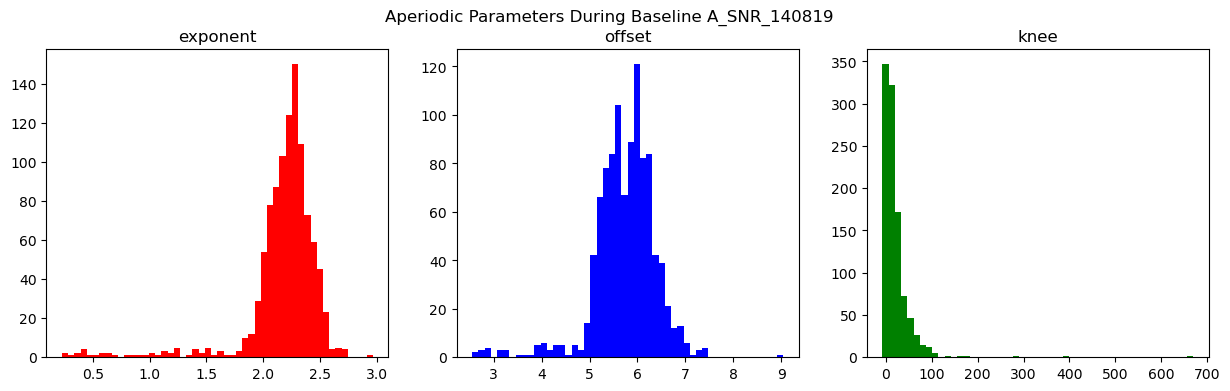

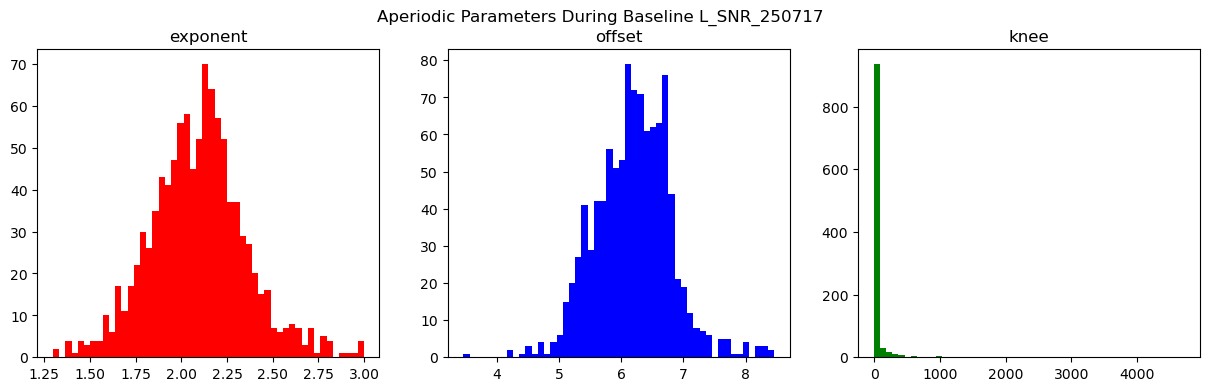

In [22]:
# plot params histogram for baseline
for session in SESSIONS:
    df = params[(params['session']  == session) & (params['epoch'] == 'pre')]

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
    #exp
    ax1.hist(df.get('exponent'), bins=50, color='red')
    ax1.set_title('exponent')

    #off
    ax2.hist(df.get('offset'), bins=50, color='blue')
    ax2.set_title('offset')

    #knee
    ax3.hist(df.get('knee'), bins=50, color='green')
    ax3.set_title('knee')

    fig.suptitle(f'Aperiodic Parameters During Baseline {session}')

## Epoched Time Series

In [23]:
lfp = np.load(fr"{EXTERNAL_PATH}\data\lfp\lfp_epochs\A_SNR_140819\NSP6_array11_LFP.npy")

In [25]:
lfp.shape

(170, 64, 500)

In [112]:
# create time-vector
n_seconds = lfp.shape[2]/FS
time = create_times(n_seconds, FS)
print(time.shape)

# set signal
signal = lfp[1,1,:]
signal.shape

(500,)


(500,)

Text(0.5, 0, 'time (s)')

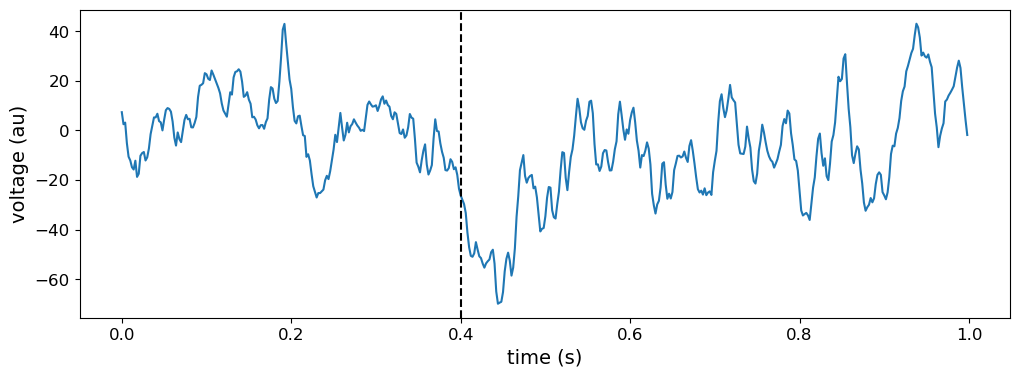

In [123]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(time, signal)
ax.axvline(x=0.4, c='black', linestyle='--')
ax.set_ylabel('voltage (au)')
ax.set_xlabel('time (s)')

## Analyze spectral epoch difference

In [4]:
for session in SESSIONS:
    print(session)

A_SNR_140819
L_SNR_250717


In [5]:
dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_psd"
data = np.load(f"{dir_input}/A_SNR_140819_spectra.npz")

In [8]:
for x in data.keys():
    print(x)

spectra_pre
spectra_post
freq


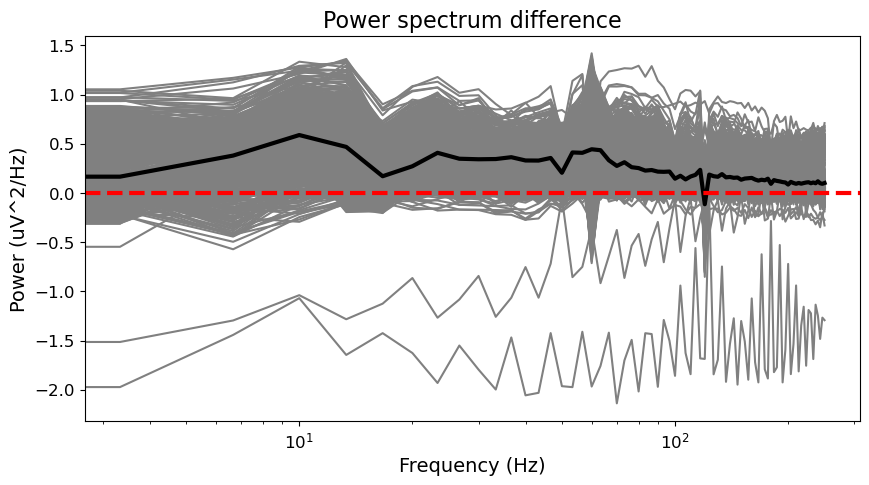

In [13]:
spectra_pre = np.nanmean(data['spectra_pre'], axis=0)
spectra_post = np.nanmean(data['spectra_post'], axis=0)
psd_diff = np.log10(spectra_post) - np.log10(spectra_pre)
plot_psd_diff(data['freq'], psd_diff)

## Plot Schematic differences

In [3]:
# define odml file path (contains metadata including electrode positions)
odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{SESSIONS[0]}/metadata_{SESSIONS[0]}.odml"

In [4]:
# load NEW spectral parameters
df = pd.read_csv(fR"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
df

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
0,A_SNR_140819,0,0,1,pre,5.774364,-6.789797,2.264008,9.805430,0.663349,5.275753,17.365468,0.618030,10.053661,60.675713,0.575678,2.164377,0.064003,0.994617
1,A_SNR_140819,1,1,1,pre,6.041152,4.586532,2.449866,NaN,NaN,NaN,16.674368,0.648848,12.000000,60.706228,0.607547,2.080446,0.075752,0.991611
2,A_SNR_140819,2,2,1,pre,5.513418,-3.240593,1.956623,10.471750,0.483946,4.875697,17.742891,0.396295,12.000000,60.127900,0.400871,2.001077,0.065324,0.990826
3,A_SNR_140819,3,3,1,pre,6.029085,7.909415,2.459045,NaN,NaN,NaN,17.123952,0.615339,12.000000,60.970030,0.667564,2.000000,0.074475,0.991993
4,A_SNR_140819,4,4,1,pre,5.998930,7.405537,2.411469,NaN,NaN,NaN,17.093011,0.599103,12.000000,60.682388,0.671076,2.228288,0.071394,0.992443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,NaN,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753
4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,NaN,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501
4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,NaN,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839
4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,NaN,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195


In [5]:
for i_session, session in enumerate(SESSIONS):

    # create directory for figure output
    dir_figs = f"{EXTERNAL_PATH}/figures/params_schematic/{session}"
    if not os.path.exists(dir_figs):
        os.makedirs(dir_figs)


    # get data for session
    df_session = df[df['session']==session]
    df_pre = df_session[df_session['epoch'] == 'pre']
    df_post = df_session[df_session['epoch'] == 'post']

    # define odml file path (contains metadata including electrode positions)
    odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"

    # look through features
    for var in ['offset', 'exponent']:
        # setting limits for colorbar
        all_values = np.append(df_pre[f"{var}"], df_post[f"{var}"])
        maxli = np.nanmax(all_values)
        minli = np.nanmin(all_values)

        # pre-stimulus
        plot_schematic(df_pre[f"{var}"], odml_path, title=f"session: {session}", 
                        label=f"pre-stimulus {var}", vmin=minli, vmax=maxli, 
                        fname_out=f"{dir_figs}/{session}_{var}_pre.png");
        # post-stimulus
        plot_schematic(df_post[f"{var}"], odml_path, title=f"session: {session}", 
                        label=f"post-stimulus {var}", vmin=minli, vmax=maxli, 
                        fname_out=f"{dir_figs}/{session}_{var}_post.png");

        # change in exponent
        diff = df_post[f"{var}"] - df_pre[f"{var}"]
        plot_schematic(diff, odml_path, norm_type="centered", title=f"session: {session}", 
                        label=f"difference in {var}", vmin=np.nanmin(diff), vmax=np.nanmax(diff), 
                        fname_out=f"{dir_figs}/{session}_{var}_diff.png");

        plt.close('all')

        

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element 

: 